In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import scipy.stats as stats
from datum import *
import model
import sys

In [2]:
vali_list = []
test_list = []
base_vali_list = []
base_test_list = []

In [3]:
def select(top_num, vali, test):
    vali_abs = np.abs(vali)
    arg_sort = np.argsort(vali_abs)
    select_arg = arg_sort[-top_num:]
    print('minimum: {}'.format(vali[select_arg[0]]))
    select_vali = vali[select_arg]
    select_test = test[select_arg]
    true_test = np.abs(select_test)
    #true_test = np.nan_to_num(select_test * select_vali / np.abs(select_vali))
    print('mean: {}'.format(true_test.mean()))
    return true_test, select_arg

In [4]:
list_data = []
list_mod = []
for i in range(3):
    data = Datum('{}_{}_{}'.format(2005010120150101+i, 2015010120160101, 'year'))
    data.data_prepare()
    data.get_embedding()
    data.supervised_data_prepare()
    data.ic_prepare()
    list_data.append(data)

    reload(model)
    tf.reset_default_graph()
    mod = model.Model(1, '{}_{}_{}'.format(2005010120150101+i, 2015010120160101, 'year'))
    mod.data_initial(data)
    mod.data_split()
    mod.factor_network() 
    list_mod.append(mod)
    
    for j in range(3):
        model_num = j
        saver = tf.train.Saver(max_to_keep=50)
        data_dir = '/data/zhige_data/embedding_simpyear/'
        with tf.Session() as sess:
            saver.restore(sess, data_dir+'{}model_{}/logmodel.ckpt'.format(model_num, mod.param))
            rank_ic = np.zeros((mod.vali_test-mod.train_vali, 44, 4))
            embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
            for count_day, day in enumerate(range(mod.train_vali,mod.vali_test)):#batch_num
                for fac_idx in range(44):
                    feature = mod.data.feature_data[:, day, fac_idx]
                    if feature.std() != 0:
                        feature = (feature-feature.min()) / (feature.max() - feature.min())
                    else:
                        continue
                    label = mod.data.ar_ic[:, day, 2]
                    feed_dict = {mod.embedding: embedding, mod.factor: feature, mod.factor_index: [fac_idx], mod.ic: label}
                    new_f, loss_val = sess.run([mod.new_f, mod.cost], feed_dict=feed_dict)
                    for ic_idx in range(4):
                        rank_ic[count_day, fac_idx, ic_idx] = stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], new_f)[0]
            vali_ic_mean = rank_ic.mean(axis=0)[:, 2]
            vali_list.append(vali_ic_mean)

            rank_ic = np.zeros((mod.day_sample-mod.vali_test, 44, 4))
            embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
            print('test: model:{}'.format(model_num))
            for count_day, day in enumerate(range(mod.vali_test, mod.day_sample)):#batch_num
                for fac_idx in range(44):
                    feature = mod.data.feature_data[:, day, fac_idx]
                    if feature.std() != 0:
                        feature = (feature-feature.min()) / (feature.max() - feature.min())
                    else:
                        continue
                    label = mod.data.ar_ic[:, day, 2]
                    feed_dict = {mod.embedding: embedding, mod.factor: feature, mod.factor_index: [fac_idx], mod.ic: label}
                    new_f, loss_val = sess.run([mod.new_f, mod.cost], feed_dict=feed_dict)
                    for ic_idx in range(4):
                        rank_ic[count_day, fac_idx, ic_idx] = stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], new_f)[0]
            avg_ic = rank_ic.mean(axis=0)[:, 2]
            test_list.append(avg_ic)
            print(np.abs(avg_ic))
            print(np.abs(avg_ic).mean())         
    

INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2005010120150101_2015010120160101_year/logmodel.ckpt
test: model:0
[0.00401945 0.06787332 0.04256442 0.01186373 0.05217907 0.0506689
 0.01264323 0.00941559 0.00281997 0.05234532 0.05071197 0.00532489
 0.00392844 0.01075706 0.01326652 0.02337866 0.01414303 0.01070715
 0.0038203  0.05757898 0.         0.01506554 0.04472947 0.05169319
 0.05916499 0.05220496 0.         0.05833952 0.06215312 0.01424303
 0.03471463 0.02012328 0.         0.01053075 0.00095253 0.00264158
 0.01165454 0.00011949 0.01425283 0.03735863 0.00281765 0.01340457
 0.0343092  0.01368651]
0.023958409244657097
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/1model_2005010120150101_2015010120160101_year/logmodel.ckpt
test: model:1
[0.00519271 0.0665718  0.04187916 0.00863811 0.05516935 0.01709888
 0.01692433 0.00989168 0.01202159 0.01987335 0.00832411 0.05741111
 0.00083969 0.00817735 0.02000494 0.02685871 0.01

In [5]:
rank_ic = np.zeros((mod.vali_test-mod.train_vali, 44, 4))
for count_day, day in enumerate(range(mod.train_vali,mod.vali_test)):#batch_num
    for fac_idx in range(44):
        feature = mod.data.feature_data[:, day, fac_idx]
        for ic_idx in range(4):
            rank_ic[count_day, fac_idx, ic_idx] = np.nan_to_num(stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], feature)[0])
vali_ic_mean = rank_ic.mean(axis=0)[:, 2]
base_vali_list.append(vali_ic_mean)           

rank_ic = np.zeros((mod.day_sample-mod.vali_test, 44, 4))
for count_day, day in enumerate(range(mod.vali_test, mod.day_sample)):#batch_num
    for fac_idx in range(44):
        feature = mod.data.feature_data[:, day, fac_idx]
        for ic_idx in range(4):
            rank_ic[count_day, fac_idx, ic_idx] = np.nan_to_num(stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], feature)[0])
avg_ic = rank_ic.mean(axis=0)[:, 2]
base_test_list.append(avg_ic)
print(np.abs(avg_ic))
print(np.abs(avg_ic).mean())             

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


[0.02992262 0.05695207 0.0027787  0.01346575 0.06038144 0.04932776
 0.02468884 0.0135857  0.05175637 0.02355154 0.00050478 0.01684573
 0.02519566 0.01228002 0.00130508 0.00338345 0.01030171 0.01269824
 0.01952223 0.03639059 0.         0.00878572 0.01781908 0.02265384
 0.06139434 0.02067451 0.         0.02891405 0.03493854 0.01630293
 0.02182592 0.03305655 0.         0.00722727 0.00431251 0.00422813
 0.00453825 0.04916975 0.00037841 0.0157168  0.00836063 0.00669051
 0.01987887 0.05166437]
0.020531119588852644


In [14]:
mean = 0
for i in range(9):
    select_fac, select_arg = select(10, vali_list[i], test_list[i])
    mean += select_fac.mean()
print(mean / 9)

minimum: -0.0618400621218
mean: 0.0329423803682
minimum: -0.0558313087437
mean: 0.027386178848
minimum: 0.0567221046828
mean: 0.0253573208902
minimum: -0.0596140845854
mean: 0.0273883355039
minimum: -0.0660018916833
mean: 0.0301081214131
minimum: -0.0603054503604
mean: 0.0281924767172
minimum: -0.060734077485
mean: 0.0267108515366
minimum: -0.0599099010413
mean: 0.0254367924006
minimum: -0.0600357382565
mean: 0.0285551386712
0.0280086218166


In [15]:
select_fac, select_arg = select(10, base_vali_list[-1], base_test_list[-1])

minimum: -0.123104440843
mean: 0.0223935175723


In [17]:
pd.DataFrame(np.abs(np.array(test_list)).mean(axis=0)).to_csv(data_dir+'test_2015.csv')

In [18]:
pd.DataFrame(np.abs(np.array(base_test_list)).mean(axis=0)).to_csv(data_dir+'baseline_test_2015.csv')

# Visualize Weights

In [6]:
list_confidence = []

for i in range(3):
    data = Datum('{}_{}_{}'.format(2005010120150101+i, 2015010120160101, 'year'))
    data.data_prepare()
    data.get_embedding()
    

    reload(model)
    tf.reset_default_graph()
    mod = model.Model(1, '{}_{}_{}'.format(2005010120150101+i, 2015010120160101, 'year'))
    mod.data_initial(data)
    mod.factor_network() 
    
    
    for j in range(3):
        model_num = j
        saver = tf.train.Saver(max_to_keep=50)
        with tf.Session() as sess:
            saver.restore(sess, data_dir+'{}model_{}/logmodel.ckpt'.format(model_num, mod.param))
            embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
            hold_place = np.zeros(len(mod.data.list_stocks))
            feed_dict = {mod.embedding: embedding, mod.factor: hold_place, mod.factor_index: [0], mod.ic: hold_place}
            u_bias = sess.run(mod.u_bias, feed_dict=feed_dict)
        hidden = np.matmul(embedding, u_bias.T)
        confidence = np.exp(hidden) / np.sum(np.exp(hidden), axis=0)
        list_confidence.append(confidence)

INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2005010120150101_2015010120160101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/1model_2005010120150101_2015010120160101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/2model_2005010120150101_2015010120160101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2005010120150102_2015010120160101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/1model_2005010120150102_2015010120160101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/2model_2005010120150102_2015010120160101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2005010120150103_2015010120160101_year/logmodel.ckpt
INFO:tensorflow:Restoring paramete

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
for num, confidence in enumerate([list_confidence[0]]):
    print('count: {}'.format(num))
    for fac_idx in range(44):
        print(list_data[0].indicator[fac_idx])
        arg_sort = confidence[:, fac_idx].argsort()
        print('  the max:')
        for arg in arg_sort[-10:]:
            stock = list_data[num].list_stocks[arg]
            try:
                name = data.dict_code2name[stock].split(';')[-2]
            except:
                name = 'not know'
            print('    ', stock, name, confidence[arg, fac_idx])
        
        print('  the min:')
        for arg in arg_sort[:10]:
            stock = list_data[num].list_stocks[arg]
            try:
                name = data.dict_code2name[stock].split(';')[-2]
            except:
                name = 'not know'
            print('    ', stock, name, confidence[arg, fac_idx])        

count: 0
rise_percent
  the max:
     002552 机械-宝鼎科技 0.001558096148718191
     002491 通信-通鼎互联 0.0015582505915280663
     002184 机械-海得控制 0.0015801676852282259
     300380 计算机-安硕信息 0.0016327764990106232
     300245 计算机-天玑科技 0.0016331622587516285
     300266 电力及公用事业-兴源环境 0.0017510363296854442
     300287 计算机-飞 利 信 0.0017921083688252264
     300226 传媒-上海钢联 0.0018079925047994633
     300246 医药-宝 莱 特 0.0018289255077370212
     300231 计算机-银信科技 0.0018582403868572324
  the min:
     600868 电力及公用事业-梅雁吉祥 1.2618663970154113e-05
     000509 建材-华塑控股 1.3889134082753464e-05
     600917 电力及公用事业-重庆燃气 1.7857981265667993e-05
     600609 汽车-ST 金 杯 2.2251898572429478e-05
     300330 计算机-华虹计通 2.3386408137498508e-05
     600733 房地产-S  前 锋 2.3519914265362927e-05
     000038 房地产-深 大 通 2.4291960431113452e-05
     000622 汽车-恒立实业 2.5234028690257085e-05
     000010 建筑-美丽生态 2.5486951580841796e-05
     601558 电力设备-*ST 锐电 2.6298289190509445e-05
K_length
  the max:
     600604 房地产-市北高新 0.0006682619970101397
     603699

     600028 石油石化-中国石化 0.0030904983421513126
     600018 交通运输-上港集团 0.0031562157394764397
     601288 银行-农业银行 0.0032107123293643298
     601939 银行-建设银行 0.003215781955328993
     601111 交通运输-中国国航 0.003228828541536108
     600096 建材-云 天 化 0.003248517843812329
     601600 有色金属-中国铝业 0.0033709438368149285
  the min:
     002569 纺织服装-步森股份 6.03596492083388e-07
     300381 农林牧渔-溢 多 利 8.174311377354645e-07
     601599 传媒-鹿港文化 9.111021918342787e-07
     000691 房地产-ST 亚太 9.452363257833449e-07
     000587 商贸零售-金洲慈航 9.961553323845098e-07
     002691 机械-冀凯股份 1.2913632473413098e-06
     300325 基础化工-德威新材 1.3206743473647471e-06
     002591 基础化工-恒大高新 1.3505430199022626e-06
     002613 建材-北玻股份 1.3560852546184557e-06
     002377 石油石化-国创高新 1.3906374599070614e-06
ROC_30_day
  the max:
     300085 计算机-银 之 杰 0.0014417515277057463
     300226 传媒-上海钢联 0.0014828277241454937
     000576 轻工制造-ST 甘 化 0.0014855675351223032
     300056 电力及公用事业-三 维 丝 0.001493819293554881
     300380 计算机-安硕信息 0.0015478024369869371
     3

     600711 有色金属-盛屯矿业 0.014546105471073278
     601225 煤炭-陕西煤业 0.0183508206524541
     002260 家电-德奥通航 0.02977459556169699
     600892 传媒-大晟文化 0.06485534130339063
  the min:
     000628 房地产-高新发展 1.4782623322217175e-07
     600556 房地产-ST 慧 球 1.63868463430922e-07
     000750 非银行金融-国海证券 2.1653858340700222e-07
     600701 综合-*ST 工新 2.1682677403212064e-07
     000605 电力及公用事业-渤海股份 2.2364532334106094e-07
     300222 电力设备-科大智能 2.254393735431414e-07
     600421 综合-仰帆控股 3.230232914348267e-07
     000558 房地产-莱茵体育 3.799154340539079e-07
     300201 汽车-海 伦 哲 4.849851492227444e-07
     600986 建筑-Ｇ 科 达 5.07070056909187e-07
short_high_point_K_length_day
  the max:
     300245 计算机-天玑科技 0.001575352284988094
     600767 房地产-运盛医疗 0.0015805038758632543
     002468 交通运输-申通快递 0.0016113388711791138
     300246 医药-宝 莱 特 0.001637743856103299
     603328 电子元器件-依顿电子 0.0016700861864541628
     300081 通信-恒信东方 0.0017475833787819733
     300231 计算机-银信科技 0.0017847327165445915
     300287 计算机-飞 利 信 0.001799273238906235
 

     600746 基础化工-Ｇ 索 普 3.106791031165618e-05
SHP_current_date_K_line_num_day.1
  the max:
     600751 交通运输-天海投资 0.0009860475708770018
     000301 电力及公用事业-东方市场 0.0010184112794762966
     600145 机械-*ST 新亿 0.0010335878832677537
     002581 基础化工-未名医药 0.0010405188084733061
     600715 传媒-文投控股 0.001085819153069506
     300402 机械-宝色股份 0.0010874547754506777
     300356 电子元器件-光一科技 0.001103861607532472
     002730 电力设备-电光科技 0.0011436013459249518
     002336 商贸零售-*ST 人乐 0.0011985806605861451
     002153 计算机-石基信息 0.001305718151233616
  the min:
     300381 农林牧渔-溢 多 利 7.633338281490092e-05
     002625 汽车-龙生股份 8.679690133467548e-05
     603333 电力设备-明星电缆 9.192988750745528e-05
     600647 房地产-Ｇ 同 达 9.51641260100054e-05
     000633 有色金属-*ST 合金 9.951435325287347e-05
     603399 有色金属-新 华 龙 0.00010335708921444408
     603126 电力及公用事业-中材节能 0.00011325131184439138
     002538 基础化工-司 尔 特 0.0001147266543595102
     600335 汽车-国机汽车 0.00011738155045575931
     000676 电力设备-智度股份 0.00011755701021592722
SHP_current_da

     000509 建材-华塑控股 6.370110768660996e-06
     600868 电力及公用事业-梅雁吉祥 7.144444979085447e-06
     000010 建筑-美丽生态 1.0622853193152742e-05
     000622 汽车-恒立实业 1.1566126046897806e-05
     000038 房地产-深 大 通 1.2748492869966483e-05
     300330 计算机-华虹计通 1.3519551284013967e-05
     600917 电力及公用事业-重庆燃气 1.4733358742854785e-05
     600747 房地产-大连控股 1.6540921872242766e-05
     000757 汽车-浩物股份 1.6700410620039546e-05
     600083 建筑-博信股份 1.705880223913743e-05
SHP_current_date_K_line_num_day.3
  the max:
     600084 食品饮料-中葡股份 0.004368379161772087
     000890 机械-Ｇ法尔胜 0.0046454816976376845
     300240 交通运输-飞 力 达 0.005969388073962997
     600760 国防军工-*ST 黑豹 0.0060512118729020995
     600192 电力设备-Ｇ 电 工 0.006106759154549547
     000995 食品饮料-ST 皇 台 0.0062217377590507396
     600405 通信-Ｇ动力源 0.009042831020506322
     603128 交通运输-华贸物流 0.009589478448019688
     000504 传媒-*ST 生物 0.3541445994222333
     600753 建材-东方银星 0.38774887706485384
  the min:
     300112 机械-万讯自控 6.369628456252707e-10
     000835 传媒-长城动漫 1.082017576

In [131]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
for num, confidence in enumerate([list_confidence[0]]):
    print('count: {}'.format(num))
    for fac_idx in range(44):
        print(list_data[0].indicator[fac_idx])
        arg_sort = confidence[:, fac_idx].argsort()
        print('  the max:')
        for arg in arg_sort[-10:]:
            stock = list_data[num].list_stocks[arg]
            try:
                name = data.dict_code2name[stock].split(';')[-2]
            except:
                name = 'not know'
            print('    ', stock, name, confidence[arg, fac_idx])
        
        print('  the min:')
        for arg in arg_sort[:10]:
            stock = list_data[num].list_stocks[arg]
            try:
                name = data.dict_code2name[stock].split(';')[-2]
            except:
                name = 'not know'
            print('    ', stock, name, confidence[arg, fac_idx])        

count: 0
rise_percent
  the max:
     002552 机械-宝鼎科技 0.001558096148718191
     002491 通信-通鼎互联 0.0015582505915280663
     002184 机械-海得控制 0.0015801676852282259
     300380 计算机-安硕信息 0.0016327764990106232
     300245 计算机-天玑科技 0.0016331622587516285
     300266 电力及公用事业-兴源环境 0.0017510363296854442
     300287 计算机-飞 利 信 0.0017921083688252264
     300226 传媒-上海钢联 0.0018079925047994633
     300246 医药-宝 莱 特 0.0018289255077370212
     300231 计算机-银信科技 0.0018582403868572324
  the min:
     600868 电力及公用事业-梅雁吉祥 1.2618663970154113e-05
     000509 建材-华塑控股 1.3889134082753464e-05
     600917 电力及公用事业-重庆燃气 1.7857981265667993e-05
     600609 汽车-ST 金 杯 2.2251898572429478e-05
     300330 计算机-华虹计通 2.3386408137498508e-05
     600733 房地产-S  前 锋 2.3519914265362927e-05
     000038 房地产-深 大 通 2.4291960431113452e-05
     000622 汽车-恒立实业 2.5234028690257085e-05
     000010 建筑-美丽生态 2.5486951580841796e-05
     601558 电力设备-*ST 锐电 2.6298289190509445e-05
K_length
  the max:
     600604 房地产-市北高新 0.0006682619970101397
     603699

mean_amplitude_20_day
  the max:
     300081 通信-恒信东方 0.0010509681645772568
     300071 传媒-华谊嘉信 0.0010604841336314026
     300169 基础化工-天晟新材 0.0010633073786018227
     300009 医药-安科生物 0.001082875253802578
     300314 医药-戴维医疗 0.0010899540864905625
     300287 计算机-飞 利 信 0.001095109089606802
     300231 计算机-银信科技 0.0011198635381559079
     300380 计算机-安硕信息 0.0012175851115404565
     300246 医药-宝 莱 特 0.0012481334011146968
     000802 传媒-北京文化 0.00140053270976772
  the min:
     000509 建材-华塑控股 4.66929856893699e-05
     600868 电力及公用事业-梅雁吉祥 4.8170438482694186e-05
     000622 汽车-恒立实业 5.376442494838441e-05
     000010 建筑-美丽生态 5.939046985740558e-05
     600579 汽车-天 华 院 6.929516251549244e-05
     000038 房地产-深 大 通 7.178763859235222e-05
     600609 汽车-ST 金 杯 7.450169134213156e-05
     600301 基础化工-ST 南化 7.744093792459063e-05
     600605 商贸零售-汇通能源 7.763432534586869e-05
     601558 电力设备-*ST 锐电 7.872003929990744e-05
mean_amplitude_30_day
  the max:
     300081 通信-恒信东方 0.001119000398077604
     300266 电力及公用事业-

     300194 医药-福安药业 0.016107962863086613
     000922 电力设备-*ST 佳电 0.02132210985012637
     002703 汽车-浙江世宝 0.027061702806136543
     600301 基础化工-ST 南化 0.029824709489807495
     600579 汽车-天 华 院 0.03361169757022076
     603099 餐饮旅游-长 白 山 0.03471471288550207
     600556 房地产-ST 慧 球 0.03489371605183252
     300388 电力及公用事业-国祯环保 0.035051309508789694
     603306 汽车-华懋科技 0.04973864571043946
     600781 医药-辅仁药业 0.05663325304773397
  the min:
     300350 交通运输-华 鹏 飞 5.1749142029446056e-08
     300362 电力及公用事业-天翔环境 5.6641316342962825e-08
     300373 电子元器件-扬杰科技 6.968940834866321e-08
     002718 建材-友邦吊顶 1.1762365049779733e-07
     002468 交通运输-申通快递 1.3258286047288276e-07
     601038 机械-一拖股份 1.3751404133487044e-07
     002493 石油石化-荣盛石化 1.6517768053986627e-07
     600889 基础化工-S 宁化纤 1.8258319415568397e-07
     600745 房地产-中茵股份 1.897231555288535e-07
     600746 基础化工-Ｇ 索 普 2.2640311427877692e-07
short_low_point_K_length_day
  the max:
     600030 非银行金融-Ｇ 中 信 0.0020461655439278767
     600489 有色金属-Ｇ中黄金 0.002144

     000757 汽车-浩物股份 1.6700410620039546e-05
     600083 建筑-博信股份 1.705880223913743e-05
SHP_current_date_K_line_num_day.3
  the max:
     600084 食品饮料-中葡股份 0.004368379161772087
     000890 机械-Ｇ法尔胜 0.0046454816976376845
     300240 交通运输-飞 力 达 0.005969388073962997
     600760 国防军工-*ST 黑豹 0.0060512118729020995
     600192 电力设备-Ｇ 电 工 0.006106759154549547
     000995 食品饮料-ST 皇 台 0.0062217377590507396
     600405 通信-Ｇ动力源 0.009042831020506322
     603128 交通运输-华贸物流 0.009589478448019688
     000504 传媒-*ST 生物 0.3541445994222333
     600753 建材-东方银星 0.38774887706485384
  the min:
     300112 机械-万讯自控 6.369628456252707e-10
     000835 传媒-长城动漫 1.0820175764823412e-09
     300247 家电-乐金健康 1.475710350091191e-09
     300249 家电-依 米 康 2.7106825813488895e-09
     600758 煤炭-红阳能源 2.887207026742905e-09
     002288 电子元器件-超华科技 3.0122869098553206e-09
     000633 有色金属-*ST 合金 4.270705529336313e-09
     300109 医药-新 开 源 4.573313771855211e-09
     002592 汽车-八菱科技 4.963197041776291e-09
     002667 综合-鞍重股份 5.064306621632266e-

# Prediction

In [39]:
data = list_data[0]
hushen300 = np.load('stock_code.npy')
rank_info = np.load('rank_info.npy')
use_index = []
label_rank = []

for i in range(len(data.list_stocks)):
    if int(data.list_stocks[i]) in hushen300:
        use_index.append(i)
        label_rank.append(rank_info[:, 0, np.where(hushen300==int(data.list_stocks[i]))[0][0]])
raw_feature = data.feature_data[np.array(use_index), :, :]
date = np.load('date_list.npy')

label_rank = np.array(label_rank)[:, np.where((date >= '2015-01-01') & (date < '2016-01-01'))[0]]
next_return = label_rank

In [40]:
new_feature = np.zeros(data.feature_data.shape)
tf.reset_default_graph()
model_num = 0
mod = list_mod[1]
mod.factor_network() 
saver = tf.train.Saver(max_to_keep=50)
with tf.Session() as sess:
    saver.restore(sess, data_dir+'{}model_{}/logmodel.ckpt'.format(model_num, mod.param))
    embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
    for day in range(mod.day_sample):
        for fac_idx in range(44):
            feature = mod.data.feature_data[:, day, fac_idx]
            if feature.std() != 0:
                feature = (feature-feature.min()) / (feature.max() - feature.min())
            else:
                continue
            label = mod.data.ar_ic[:, day, 2]
            feed_dict = {mod.embedding: embedding, mod.factor: feature, mod.factor_index: [fac_idx], mod.ic: label}
            new_f, loss_val = sess.run([mod.new_f, mod.cost], feed_dict=feed_dict)
            new_feature[:, day, fac_idx] = new_f
new_feature = new_feature[np.array(use_index), :, :]

INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2005010120150102_2015010120160101_year/logmodel.ckpt


In [41]:

train_raw_feature = raw_feature[:, :mod.train_vali, :].reshape(-1, 44)
vali_raw_feature = raw_feature[:, mod.train_vali:mod.vali_test, :].reshape(-1, 44)
test_raw_feature = raw_feature[:, mod.vali_test:, :].reshape(-1 , 44)

# train_new_feature = np.concatenate((new_feature[:, :mod.train_vali, :].reshape(-1, 44), train_raw_feature), axis=1)
# vali_new_feature = np.concatenate((new_feature[:, mod.train_vali:mod.vali_test, :].reshape(-1, 44), vali_raw_feature), axis=1)
# test_new_feature = np.concatenate((new_feature[:, mod.vali_test:, :].reshape(-1 , 44), test_raw_feature), axis=1)

train_new_feature = new_feature[:, :mod.train_vali, :].reshape(-1, 44)
vali_new_feature = new_feature[:, mod.train_vali:mod.vali_test, :].reshape(-1, 44)
test_new_feature = new_feature[:, mod.vali_test:, :].reshape(-1 , 44)

train_return = next_return[:, :mod.train_vali].reshape(-1)
vali_return = next_return[:, mod.train_vali:mod.vali_test].reshape(-1)
test_return = next_return[:, mod.vali_test:].reshape(-1)

'''
train_raw_feature = raw_feature[:, :mod.train_vali, :]
vali_raw_feature = raw_feature[:, mod.train_vali:mod.vali_test, :]
test_raw_feature = raw_feature[:, mod.vali_test:, :]

train_new_feature = np.concatenate((new_feature[:, :mod.train_vali, :], train_raw_feature), axis=2)
vali_new_feature = np.concatenate((new_feature[:, mod.train_vali:mod.vali_test, :], vali_raw_feature), axis=2)
test_new_feature = np.concatenate((new_feature[:, mod.vali_test:, :], test_raw_feature), axis=2)

train_return = next_return[:, :mod.train_vali]
vali_return = next_return[:, mod.train_vali:mod.vali_test]
test_return = next_return[:, mod.vali_test:]
'''
close_price = data.price_data[use_index, mod.vali_test:]

In [30]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

In [31]:
def lr_model(train_x, train_y, test_x, test_y):
    '''
    for i in range(train_x.shape[0]):
        train_x[i] = (train_x[i] - train_x[i].mean()) / train_x[i].std()
    for i in range(test_x.shape[0]):
        test_x[i] = (test_x[i] - test_x[i].mean()) / test_x[i].std()        
    '''
    # regr = linear_model.LinearRegression()
    # regr.fit(train_x, train_y)
    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_y))
    print('Variance score: %.2f' % r2_score(test_y, predict_y))
    #print(np.array(mean_error).mean())
    #print(np.array(r2_error).mean())
    return predict_y

In [45]:
def check(price, factor, turn_fee, top):
    money = 10000
    sec_own = np.zeros(factor.shape[0])
    money_sequence = []
    for day in range(price.shape[1]):
        money = money + np.sum(price[:, day] * sec_own)
        money_sequence.append(money)
        fac = factor[:, day]
        arg_sort = np.argsort(-fac)
        soft_max = np.zeros(price.shape[0])
        soft_max[arg_sort[:top]] = 1.0 / top
        # soft_max = np.exp(fac) / np.sum(np.exp(fac))
        
        sec_own_new = money * soft_max / price[:, day]
        change_fee = turn_fee * np.sum(np.abs(sec_own_new - sec_own) * price[:, day])
        money = money - change_fee
        sec_own_new = money * soft_max / price[:, day]
        sec_own = sec_own_new
        money = 0
    earn_rate = np.sum(price[:, day] * sec_own) / 10000
    return (np.power(earn_rate, 4) - 1)
        

In [33]:
raw_fac = lr_model(train_raw_feature, train_return, test_raw_feature, test_return).reshape(len(hushen300), -1)

Mean squared error: 2427.43
Variance score: -0.04


In [34]:
new_fac = lr_model(train_new_feature, train_return, test_new_feature, test_return).reshape(len(hushen300), -1)

Mean squared error: 2391.05
Variance score: -0.03


In [37]:
check(close_price, raw_fac, 0, 30)

1.6676295955545606


In [38]:
check(close_price, new_fac, 0, 30)

0.9829782036489239


# hyper paramater test

In [47]:
close_price = data.price_data[use_index, mod.train_vali:mod.vali_test]

In [48]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

In [56]:
estimators = [50, 100, 200, 300, 500, 800, 1000]
max_depths = [1, 2, 4, 6, 8, 10]
learning_rates = [0.0001, 0.001, 0.1, 0.5, 1, 5]
top_ks = [10, 20, 30, 40, 50, 70, 100]

In [52]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, vali_raw_feature, vali_return] 
result_list = []
for estimator in estimators:
    for dep in max_depths:
        for lr in learning_rates:
            params = {'n_estimators': estimator, 'max_depth': dep, 'min_samples_split': 2,
                  'learning_rate': lr, 'loss': 'ls'}
            clf = ensemble.GradientBoostingRegressor(**params)   
            clf.fit(train_x, train_y)
            predict_y = clf.predict(test_x).reshape(len(hushen300), -1)
            for top in top_k:
                result = check(close_price, predict_y, 0, top)
                print(estimator, dep, lr, top, result)
                result_list.append(result)

(50, 1, 0.0001, 10, -0.6107908308444073)
(50, 1, 0.0001, 20, -0.37086033070552493)
(50, 1, 0.0001, 30, -0.4730262343358774)
(50, 1, 0.0001, 40, -0.5115712145237327)
(50, 1, 0.0001, 50, -0.5453310323808465)
(50, 1, 0.0001, 70, -0.5247568102456834)
(50, 1, 0.0001, 100, -0.5127349700021235)
(50, 1, 0.001, 10, -0.6107908308444073)
(50, 1, 0.001, 20, -0.37086033070552493)
(50, 1, 0.001, 30, -0.4730262343358774)
(50, 1, 0.001, 40, -0.5115712145237327)
(50, 1, 0.001, 50, -0.5453310323808465)
(50, 1, 0.001, 70, -0.5247568102456834)
(50, 1, 0.001, 100, -0.5127349700021235)
(50, 1, 0.1, 10, -0.08705835237286352)
(50, 1, 0.1, 20, -0.30139908984638697)
(50, 1, 0.1, 30, -0.44211076418821316)
(50, 1, 0.1, 40, -0.4009118614307937)
(50, 1, 0.1, 50, -0.35387578079748483)
(50, 1, 0.1, 70, -0.43755508505913243)
(50, 1, 0.1, 100, -0.4216718085072829)
(50, 1, 0.5, 10, 0.28523546474982564)
(50, 1, 0.5, 20, -0.03064079612980597)
(50, 1, 0.5, 30, 0.12932398506217013)
(50, 1, 0.5, 40, -0.15667691364634118)
(50

(50, 10, 0.001, 10, 0.022336074409281315)
(50, 10, 0.001, 20, -0.03324313003887558)
(50, 10, 0.001, 30, -0.13847531727154094)
(50, 10, 0.001, 40, -0.18906692152972437)
(50, 10, 0.001, 50, -0.3555500018349129)
(50, 10, 0.001, 70, -0.3695554021670314)
(50, 10, 0.001, 100, -0.3876042457029074)
(50, 10, 0.1, 10, -0.31242387593111165)
(50, 10, 0.1, 20, -0.42695470548301373)
(50, 10, 0.1, 30, -0.37419108400504275)
(50, 10, 0.1, 40, -0.4242438882445614)
(50, 10, 0.1, 50, -0.3980504747884841)
(50, 10, 0.1, 70, -0.3938315823549855)
(50, 10, 0.1, 100, -0.4039882699725842)
(50, 10, 0.5, 10, -0.7522714398988086)
(50, 10, 0.5, 20, -0.6075182121148376)
(50, 10, 0.5, 30, -0.4411083073559988)
(50, 10, 0.5, 40, -0.4073203071400513)
(50, 10, 0.5, 50, -0.4191075760725964)
(50, 10, 0.5, 70, -0.4412055572114122)
(50, 10, 0.5, 100, -0.4481595209707757)
(50, 10, 1, 10, -0.4110981941502826)
(50, 10, 1, 20, -0.5395172408257207)
(50, 10, 1, 30, -0.6251646260317625)
(50, 10, 1, 40, -0.5870073521637957)
(50, 10, 

(100, 8, 0.001, 10, 0.04433360314468904)
(100, 8, 0.001, 20, -0.3825719404754141)
(100, 8, 0.001, 30, -0.38558835633260413)
(100, 8, 0.001, 40, -0.5013796067710838)
(100, 8, 0.001, 50, -0.5089685559193882)
(100, 8, 0.001, 70, -0.4949730470074126)
(100, 8, 0.001, 100, -0.5014718572730793)
(100, 8, 0.1, 10, -0.6144113017688033)
(100, 8, 0.1, 20, -0.4675099713048978)
(100, 8, 0.1, 30, -0.37003772076508923)
(100, 8, 0.1, 40, -0.3496616037712851)
(100, 8, 0.1, 50, -0.3573591853731638)
(100, 8, 0.1, 70, -0.37840193968845204)
(100, 8, 0.1, 100, -0.4600132076585699)
(100, 8, 0.5, 10, 0.14720489245420998)
(100, 8, 0.5, 20, -0.3509389723714701)
(100, 8, 0.5, 30, -0.5175004621613682)
(100, 8, 0.5, 40, -0.44376226696783816)
(100, 8, 0.5, 50, -0.4076500687203636)
(100, 8, 0.5, 70, -0.45078009388141427)
(100, 8, 0.5, 100, -0.4503243059503458)
(100, 8, 1, 10, -0.7844021384375037)
(100, 8, 1, 20, -0.730291241095584)
(100, 8, 1, 30, -0.5756777373436639)
(100, 8, 1, 40, -0.5467932276092431)
(100, 8, 1, 

(200, 6, 0.001, 10, 0.09834656831795052)
(200, 6, 0.001, 20, -0.11946294699103155)
(200, 6, 0.001, 30, -0.3580300084846648)
(200, 6, 0.001, 40, -0.4402788728707232)
(200, 6, 0.001, 50, -0.4924015079190094)
(200, 6, 0.001, 70, -0.5371738508759187)
(200, 6, 0.001, 100, -0.5016700596496567)
(200, 6, 0.1, 10, -0.47622225734091317)
(200, 6, 0.1, 20, -0.4326752744108684)
(200, 6, 0.1, 30, -0.35043749500583965)
(200, 6, 0.1, 40, -0.4795429694817861)
(200, 6, 0.1, 50, -0.42513302665210906)
(200, 6, 0.1, 70, -0.494117428399667)
(200, 6, 0.1, 100, -0.4684035433406539)
(200, 6, 0.5, 10, -0.6558042358746652)
(200, 6, 0.5, 20, -0.5147661459830881)
(200, 6, 0.5, 30, -0.49134045894530554)
(200, 6, 0.5, 40, -0.419100634696689)
(200, 6, 0.5, 50, -0.3782036452118194)
(200, 6, 0.5, 70, -0.48786563034130215)
(200, 6, 0.5, 100, -0.46032985302543794)
(200, 6, 1, 10, -0.572270072161557)
(200, 6, 1, 20, -0.2337162396335437)
(200, 6, 1, 30, -0.3816501310892968)
(200, 6, 1, 40, -0.38516327017958496)
(200, 6, 1,

(300, 4, 0.001, 10, 0.05865691365968795)
(300, 4, 0.001, 20, -0.23495292946051383)
(300, 4, 0.001, 30, -0.34171121778719693)
(300, 4, 0.001, 40, -0.44335205122465093)
(300, 4, 0.001, 50, -0.4684899730853288)
(300, 4, 0.001, 70, -0.516825898269824)
(300, 4, 0.001, 100, -0.5419970863889603)
(300, 4, 0.1, 10, -0.39422755041971036)
(300, 4, 0.1, 20, -0.48598485775281997)
(300, 4, 0.1, 30, -0.3147912131543894)
(300, 4, 0.1, 40, -0.3977202295940614)
(300, 4, 0.1, 50, -0.3843633676993051)
(300, 4, 0.1, 70, -0.4455945884789593)
(300, 4, 0.1, 100, -0.48315810655182967)
(300, 4, 0.5, 10, -0.33982621970291516)
(300, 4, 0.5, 20, -0.312123338597459)
(300, 4, 0.5, 30, -0.37696122160513423)
(300, 4, 0.5, 40, -0.4258829972750331)
(300, 4, 0.5, 50, -0.3933505140884974)
(300, 4, 0.5, 70, -0.38616859413675697)
(300, 4, 0.5, 100, -0.40240671797099226)
(300, 4, 1, 10, -0.5743013833184607)
(300, 4, 1, 20, -0.5812541555777677)
(300, 4, 1, 30, -0.48060069393154226)
(300, 4, 1, 40, -0.4415662761511666)
(300, 4

(500, 2, 0.001, 10, -0.7001908597984239)
(500, 2, 0.001, 20, -0.47553148818254953)
(500, 2, 0.001, 30, -0.2839654286981538)
(500, 2, 0.001, 40, -0.34837003069419203)
(500, 2, 0.001, 50, -0.3870957321206645)
(500, 2, 0.001, 70, -0.3855176043550763)
(500, 2, 0.001, 100, -0.46509075211859785)
(500, 2, 0.1, 10, -0.4421645550006055)
(500, 2, 0.1, 20, -0.4212813864057816)
(500, 2, 0.1, 30, -0.2475394070639011)
(500, 2, 0.1, 40, -0.22803709323872334)
(500, 2, 0.1, 50, -0.3699882408174765)
(500, 2, 0.1, 70, -0.43681183406506097)
(500, 2, 0.1, 100, -0.4569513222282464)
(500, 2, 0.5, 10, -0.732909177820914)
(500, 2, 0.5, 20, -0.6129000258299834)
(500, 2, 0.5, 30, -0.5080369129130164)
(500, 2, 0.5, 40, -0.543649271506268)
(500, 2, 0.5, 50, -0.5366393754885151)
(500, 2, 0.5, 70, -0.4812975808023018)
(500, 2, 0.5, 100, -0.48864621036518074)
(500, 2, 1, 10, -0.6667834791200686)
(500, 2, 1, 20, -0.5958380379536137)
(500, 2, 1, 30, -0.4457960255730903)
(500, 2, 1, 40, -0.47424198544195206)
(500, 2, 1,

(800, 1, 0.001, 10, -0.7404297338586638)
(800, 1, 0.001, 20, -0.5582269404109665)
(800, 1, 0.001, 30, -0.49015458657402766)
(800, 1, 0.001, 40, -0.44551451943120224)
(800, 1, 0.001, 50, -0.39536462208016077)
(800, 1, 0.001, 70, -0.4672672634488214)
(800, 1, 0.001, 100, -0.5015020648413369)
(800, 1, 0.1, 10, 0.22554963687895646)
(800, 1, 0.1, 20, 0.015366798256881475)
(800, 1, 0.1, 30, -0.20008030173227231)
(800, 1, 0.1, 40, -0.19953285580786617)
(800, 1, 0.1, 50, -0.2293412381047788)
(800, 1, 0.1, 70, -0.3291742890961856)
(800, 1, 0.1, 100, -0.4456460568031152)
(800, 1, 0.5, 10, 0.10326538950425967)
(800, 1, 0.5, 20, -0.38338869682816434)
(800, 1, 0.5, 30, -0.3974514453343142)
(800, 1, 0.5, 40, -0.45250355511553475)
(800, 1, 0.5, 50, -0.44906170675977963)
(800, 1, 0.5, 70, -0.34726777195594716)
(800, 1, 0.5, 100, -0.3866734386335182)
(800, 1, 1, 10, -0.11972847276798482)
(800, 1, 1, 20, -0.39710638571821777)
(800, 1, 1, 30, -0.49905431559182256)
(800, 1, 1, 40, -0.5039889734226519)
(80

(800, 10, 0.001, 10, -0.21658867313232388)
(800, 10, 0.001, 20, -0.24346822505359367)
(800, 10, 0.001, 30, -0.2830641475483382)
(800, 10, 0.001, 40, -0.3094664808776667)
(800, 10, 0.001, 50, -0.40434370067459513)
(800, 10, 0.001, 70, -0.36741403770066683)
(800, 10, 0.001, 100, -0.43414956134647575)
(800, 10, 0.1, 10, -0.6975451372464058)
(800, 10, 0.1, 20, -0.2048363927514839)
(800, 10, 0.1, 30, -0.3894043631489118)
(800, 10, 0.1, 40, -0.34748503545465026)
(800, 10, 0.1, 50, -0.32533861808639386)
(800, 10, 0.1, 70, -0.2621435537261041)
(800, 10, 0.1, 100, -0.3639237443934259)
(800, 10, 0.5, 10, -0.7141390093992421)
(800, 10, 0.5, 20, -0.6029234842000424)
(800, 10, 0.5, 30, -0.5350571921041903)
(800, 10, 0.5, 40, -0.47421894565324907)
(800, 10, 0.5, 50, -0.4622429285775176)
(800, 10, 0.5, 70, -0.40180088351415133)
(800, 10, 0.5, 100, -0.4825542722749522)
(800, 10, 1, 10, -0.11362374264698505)
(800, 10, 1, 20, -0.17245379782236736)
(800, 10, 1, 30, -0.04866679779474492)
(800, 10, 1, 40, 

(1000, 8, 0.0001, 10, 0.16191925334934054)
(1000, 8, 0.0001, 20, -0.3926601235915529)
(1000, 8, 0.0001, 30, -0.41393321704112174)
(1000, 8, 0.0001, 40, -0.49077904852944176)
(1000, 8, 0.0001, 50, -0.521703990340661)
(1000, 8, 0.0001, 70, -0.4975253418293706)
(1000, 8, 0.0001, 100, -0.5002424121472311)
(1000, 8, 0.001, 10, 0.043378642280494706)
(1000, 8, 0.001, 20, -0.2188217711489866)
(1000, 8, 0.001, 30, -0.45281328205641236)
(1000, 8, 0.001, 40, -0.35217600208206146)
(1000, 8, 0.001, 50, -0.35093690216942686)
(1000, 8, 0.001, 70, -0.41092918418863)
(1000, 8, 0.001, 100, -0.4267587405323633)
(1000, 8, 0.1, 10, -0.6366571492578859)
(1000, 8, 0.1, 20, -0.49977807158848897)
(1000, 8, 0.1, 30, -0.41148825174384684)
(1000, 8, 0.1, 40, -0.4007965733794796)
(1000, 8, 0.1, 50, -0.3172893741706385)
(1000, 8, 0.1, 70, -0.3766206839079659)
(1000, 8, 0.1, 100, -0.4702970870926029)
(1000, 8, 0.5, 10, -0.43585586006657817)
(1000, 8, 0.5, 20, -0.3848782045790531)
(1000, 8, 0.5, 30, -0.49944618035200

In [51]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, vali_new_feature, vali_return] 
new_result_list = []
for estimator in estimators:
    for dep in max_depths:
        for lr in learning_rates:
            
            params = {'n_estimators': estimator, 'max_depth': dep, 'min_samples_split': 2,
                  'learning_rate': lr, 'loss': 'ls'}
            clf = ensemble.GradientBoostingRegressor(**params)   
            clf.fit(train_x, train_y)
            predict_y = clf.predict(test_x).reshape(len(hushen300), -1)
            for top in top_k:
                result = check(close_price, predict_y, 0, top)
                print(estimator, dep, lr, top, result)
                new_result_list.append(result)

(50, 1, 0.0001, 10, -0.24183560763154333)
(50, 1, 0.0001, 20, -0.4331069359292229)
(50, 1, 0.0001, 30, -0.4259350631787605)
(50, 1, 0.0001, 40, -0.40047798667302814)
(50, 1, 0.0001, 50, -0.379500182088474)
(50, 1, 0.0001, 70, -0.4871481224841784)
(50, 1, 0.0001, 100, -0.47591316657166305)
(50, 1, 0.001, 10, -0.24183560763154333)
(50, 1, 0.001, 20, -0.4331069359292229)
(50, 1, 0.001, 30, -0.4259350631787605)
(50, 1, 0.001, 40, -0.40047798667302814)
(50, 1, 0.001, 50, -0.379500182088474)
(50, 1, 0.001, 70, -0.4871481224841784)
(50, 1, 0.001, 100, -0.47591316657166305)
(50, 1, 0.1, 10, -0.4084901835920991)
(50, 1, 0.1, 20, -0.42779056188663167)
(50, 1, 0.1, 30, -0.2904219719529483)
(50, 1, 0.1, 40, -0.4385905959865667)
(50, 1, 0.1, 50, -0.36849189650047065)
(50, 1, 0.1, 70, -0.48855744586981364)
(50, 1, 0.1, 100, -0.4210309505102863)
(50, 1, 0.5, 10, -0.48698947185840025)
(50, 1, 0.5, 20, -0.6206455618003641)
(50, 1, 0.5, 30, -0.48649078205379614)
(50, 1, 0.5, 40, -0.4794265823106181)
(50

(50, 10, 0.001, 10, -0.6381408474949796)
(50, 10, 0.001, 20, -0.4588719422689441)
(50, 10, 0.001, 30, -0.38654240519754257)
(50, 10, 0.001, 40, -0.410935597796493)
(50, 10, 0.001, 50, -0.5131991043489792)
(50, 10, 0.001, 70, -0.5138637160674899)
(50, 10, 0.001, 100, -0.5236537908189309)
(50, 10, 0.1, 10, -0.793949185638334)
(50, 10, 0.1, 20, -0.5249076466145504)
(50, 10, 0.1, 30, -0.30822647885410037)
(50, 10, 0.1, 40, -0.297088365115448)
(50, 10, 0.1, 50, -0.341950442704258)
(50, 10, 0.1, 70, -0.4425491125997315)
(50, 10, 0.1, 100, -0.46044108382193605)
(50, 10, 0.5, 10, -0.20641444272664133)
(50, 10, 0.5, 20, -0.40472230457362557)
(50, 10, 0.5, 30, -0.4725432213665536)
(50, 10, 0.5, 40, -0.5611039440069321)
(50, 10, 0.5, 50, -0.5518120993069091)
(50, 10, 0.5, 70, -0.44841299602977724)
(50, 10, 0.5, 100, -0.4118405511821772)
(50, 10, 1, 10, -0.49934273416125907)
(50, 10, 1, 20, -0.5286404326759244)
(50, 10, 1, 30, -0.47508897650540804)
(50, 10, 1, 40, -0.42345014185950614)
(50, 10, 1,

(100, 8, 0.001, 10, -0.5191396376319087)
(100, 8, 0.001, 20, -0.39973742090778386)
(100, 8, 0.001, 30, -0.3315548405775034)
(100, 8, 0.001, 40, -0.3923086204650097)
(100, 8, 0.001, 50, -0.4447696092696328)
(100, 8, 0.001, 70, -0.4995178950838972)
(100, 8, 0.001, 100, -0.5056844086662395)
(100, 8, 0.1, 10, -0.4441719931150795)
(100, 8, 0.1, 20, -0.5144668939476953)
(100, 8, 0.1, 30, -0.3709145817989352)
(100, 8, 0.1, 40, -0.4431149642265987)
(100, 8, 0.1, 50, -0.4420931001474324)
(100, 8, 0.1, 70, -0.39250001142854674)
(100, 8, 0.1, 100, -0.3897180371970249)
(100, 8, 0.5, 10, -0.4969358632548939)
(100, 8, 0.5, 20, -0.5242599958097962)
(100, 8, 0.5, 30, -0.3831773150059261)
(100, 8, 0.5, 40, -0.36101554203188757)
(100, 8, 0.5, 50, -0.3484915605112926)
(100, 8, 0.5, 70, -0.33646707607757875)
(100, 8, 0.5, 100, -0.3802463292016859)
(100, 8, 1, 10, -0.49381536115148505)
(100, 8, 1, 20, -0.3734149185202251)
(100, 8, 1, 30, -0.40207079921711286)
(100, 8, 1, 40, -0.4144739433651081)
(100, 8, 1

(200, 6, 0.001, 10, -0.5385878080638153)
(200, 6, 0.001, 20, -0.38860652211541946)
(200, 6, 0.001, 30, -0.5373295818305259)
(200, 6, 0.001, 40, -0.5724485993945185)
(200, 6, 0.001, 50, -0.5181480437868412)
(200, 6, 0.001, 70, -0.45594487009731455)
(200, 6, 0.001, 100, -0.45274620421715905)
(200, 6, 0.1, 10, -0.5935199080948325)
(200, 6, 0.1, 20, -0.5031913789003521)
(200, 6, 0.1, 30, -0.49111990599698463)
(200, 6, 0.1, 40, -0.49845586217896953)
(200, 6, 0.1, 50, -0.4503876152895382)
(200, 6, 0.1, 70, -0.34776485374512467)
(200, 6, 0.1, 100, -0.3494065802954155)
(200, 6, 0.5, 10, -0.5911315072857157)
(200, 6, 0.5, 20, -0.4688527349395767)
(200, 6, 0.5, 30, -0.487405361547289)
(200, 6, 0.5, 40, -0.3901157572966937)
(200, 6, 0.5, 50, -0.42551925801740353)
(200, 6, 0.5, 70, -0.4647468437054646)
(200, 6, 0.5, 100, -0.44364048347239715)
(200, 6, 1, 10, -0.42094792460487906)
(200, 6, 1, 20, -0.32343556384768524)
(200, 6, 1, 30, -0.38788210140323764)
(200, 6, 1, 40, -0.4111604637068855)
(200, 

(300, 4, 0.001, 10, -0.38041101178727577)
(300, 4, 0.001, 20, -0.47570141365938035)
(300, 4, 0.001, 30, -0.48254641364014006)
(300, 4, 0.001, 40, -0.43686305057200503)
(300, 4, 0.001, 50, -0.46381569750219565)
(300, 4, 0.001, 70, -0.45712611721670016)
(300, 4, 0.001, 100, -0.41315965181331693)
(300, 4, 0.1, 10, -0.2932225048338627)
(300, 4, 0.1, 20, -0.15979447230239296)
(300, 4, 0.1, 30, -0.24379860291384092)
(300, 4, 0.1, 40, -0.369489914366115)
(300, 4, 0.1, 50, -0.34663908503375285)
(300, 4, 0.1, 70, -0.3808359990056439)
(300, 4, 0.1, 100, -0.3745591585939101)
(300, 4, 0.5, 10, -0.35006084560465667)
(300, 4, 0.5, 20, -0.41269305953145496)
(300, 4, 0.5, 30, -0.35393958774121503)
(300, 4, 0.5, 40, -0.4313501584522367)
(300, 4, 0.5, 50, -0.45281041610180806)
(300, 4, 0.5, 70, -0.45119704717720555)
(300, 4, 0.5, 100, -0.45190478547631685)
(300, 4, 1, 10, -0.45496900756657)
(300, 4, 1, 20, -0.5347822008584805)
(300, 4, 1, 30, -0.40805305553418636)
(300, 4, 1, 40, -0.4466857854218317)
(3

(500, 2, 0.001, 10, -0.18715767352367707)
(500, 2, 0.001, 20, -0.13657476085849596)
(500, 2, 0.001, 30, -0.2956236533641945)
(500, 2, 0.001, 40, -0.3416062989894818)
(500, 2, 0.001, 50, -0.32596371617127684)
(500, 2, 0.001, 70, -0.4236331160594299)
(500, 2, 0.001, 100, -0.47957139268186066)
(500, 2, 0.1, 10, -0.5376268705972402)
(500, 2, 0.1, 20, -0.4771356332717497)
(500, 2, 0.1, 30, -0.19914419704627018)
(500, 2, 0.1, 40, -0.1611246178607354)
(500, 2, 0.1, 50, -0.23998062082220906)
(500, 2, 0.1, 70, -0.328470900478143)
(500, 2, 0.1, 100, -0.38526327948951133)
(500, 2, 0.5, 10, -0.21242641209501834)
(500, 2, 0.5, 20, -0.41883242388108266)
(500, 2, 0.5, 30, -0.3580989484385544)
(500, 2, 0.5, 40, -0.3650534137653936)
(500, 2, 0.5, 50, -0.3700347001529203)
(500, 2, 0.5, 70, -0.42477135739509086)
(500, 2, 0.5, 100, -0.4255178143349747)
(500, 2, 1, 10, -0.45454471313014166)
(500, 2, 1, 20, -0.37509263447902197)
(500, 2, 1, 30, -0.3661630301616807)
(500, 2, 1, 40, -0.369608897647943)
(500, 

(800, 1, 0.001, 10, -0.4276602693605598)
(800, 1, 0.001, 20, -0.4267458857679317)
(800, 1, 0.001, 30, -0.4558470588967507)
(800, 1, 0.001, 40, -0.5458550203969131)
(800, 1, 0.001, 50, -0.5035754900693163)
(800, 1, 0.001, 70, -0.4722055892350898)
(800, 1, 0.001, 100, -0.48336657773600633)
(800, 1, 0.1, 10, -0.5943705425767296)
(800, 1, 0.1, 20, -0.6050608809863376)
(800, 1, 0.1, 30, -0.5830815479567963)
(800, 1, 0.1, 40, -0.5447353951939216)
(800, 1, 0.1, 50, -0.4792675301280097)
(800, 1, 0.1, 70, -0.45617679431090663)
(800, 1, 0.1, 100, -0.41679201812324285)
(800, 1, 0.5, 10, -0.6915361880381163)
(800, 1, 0.5, 20, -0.4913080048259879)
(800, 1, 0.5, 30, -0.4055968411328297)
(800, 1, 0.5, 40, -0.41579865904592084)
(800, 1, 0.5, 50, -0.4597071767387896)
(800, 1, 0.5, 70, -0.46748590328799056)
(800, 1, 0.5, 100, -0.43244545510401267)
(800, 1, 1, 10, 0.008136545370363235)
(800, 1, 1, 20, -0.3929493020264063)
(800, 1, 1, 30, -0.37880941462033035)
(800, 1, 1, 40, -0.42436810676648096)
(800, 1

(800, 10, 0.001, 10, -0.21649746364583045)
(800, 10, 0.001, 20, -0.45401793705953186)
(800, 10, 0.001, 30, -0.44338099077332926)
(800, 10, 0.001, 40, -0.41094329305768573)
(800, 10, 0.001, 50, -0.45581760166600416)
(800, 10, 0.001, 70, -0.4537598983269434)
(800, 10, 0.001, 100, -0.44112197006477083)
(800, 10, 0.1, 10, -0.7810401961774924)
(800, 10, 0.1, 20, -0.7207245145002222)
(800, 10, 0.1, 30, -0.6011314758581435)
(800, 10, 0.1, 40, -0.42937680311874626)
(800, 10, 0.1, 50, -0.439502735013228)
(800, 10, 0.1, 70, -0.4575181218332012)
(800, 10, 0.1, 100, -0.4454677418618138)
(800, 10, 0.5, 10, -0.253394998153767)
(800, 10, 0.5, 20, -0.40658748612809725)
(800, 10, 0.5, 30, -0.4262926001375077)
(800, 10, 0.5, 40, -0.44121252691710555)
(800, 10, 0.5, 50, -0.46211129761982195)
(800, 10, 0.5, 70, -0.5224382119227061)
(800, 10, 0.5, 100, -0.49025609936535786)
(800, 10, 1, 10, -0.2308005132010843)
(800, 10, 1, 20, -0.4448486390698322)
(800, 10, 1, 30, -0.49147175361581097)
(800, 10, 1, 40, -0

(1000, 8, 0.0001, 10, -0.533655412675808)
(1000, 8, 0.0001, 20, -0.4183347529866456)
(1000, 8, 0.0001, 30, -0.3365141793819304)
(1000, 8, 0.0001, 40, -0.3855627105798851)
(1000, 8, 0.0001, 50, -0.4366153833424459)
(1000, 8, 0.0001, 70, -0.49231178610683424)
(1000, 8, 0.0001, 100, -0.5083532637068541)
(1000, 8, 0.001, 10, -0.4639275636092729)
(1000, 8, 0.001, 20, -0.46545270776394754)
(1000, 8, 0.001, 30, -0.41546727934425987)
(1000, 8, 0.001, 40, -0.40410294585023976)
(1000, 8, 0.001, 50, -0.4313603398592647)
(1000, 8, 0.001, 70, -0.5258833208159022)
(1000, 8, 0.001, 100, -0.42717660818910785)
(1000, 8, 0.1, 10, -0.5271850182819061)
(1000, 8, 0.1, 20, -0.4639560846186538)
(1000, 8, 0.1, 30, -0.41335464749123096)
(1000, 8, 0.1, 40, -0.4378089843235874)
(1000, 8, 0.1, 50, -0.41291188663968015)
(1000, 8, 0.1, 70, -0.36559826966713027)
(1000, 8, 0.1, 100, -0.35037476622308006)
(1000, 8, 0.5, 10, 0.22499392078747738)
(1000, 8, 0.5, 20, -0.2594038551815899)
(1000, 8, 0.5, 30, -0.336865407714

In [54]:
def get_param(num):
    topk = num % 7
    num = (num - 7 * topk) // 7
    lr = num % 6
    num = (num - 6 * lr) // 6
    dep = num % 6
    num = (num - 6 * dep) // 6
    estimate = num % 7
    return estimators[int(estimate)], max_depths[int(dep)], learning_rates[int(lr)], top_ks[int(topk)]
    

In [60]:
close_price = data.price_data[use_index, mod.vali_test:]
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
select_result = []
a_result = np.array(result_list)
arg_result = np.argsort(-a_result)
n = 10
for arg in arg_result[:n]:
    estimator, dep, lr, topk = get_param(arg)
    params = {'n_estimators': int(estimator), 'max_depth': int(dep), 'min_samples_split': 2,
          'learning_rate': lr, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)   
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x).reshape(len(hushen300), -1)
    result = check(close_price, predict_y, 0, top)
    print(estimator, dep, lr, top, result)
    select_result.append(result)    

(800, 2, 0.001, 100, 0.883374744321489)
(50, 4, 1, 100, 0.7984206139657455)
(500, 6, 1, 100, 0.6527160056696624)
(100, 4, 0.001, 100, 0.9537771801526949)
(500, 4, 0.001, 100, 0.7842667122641351)
(200, 6, 0.5, 100, 0.9202648667709394)
(100, 8, 0.0001, 100, 0.8699924555663667)
(500, 2, 0.001, 100, 0.8321217432523096)
(200, 10, 0.1, 100, 0.7313995259312831)
(100, 8, 0.1, 100, 0.7306182480032197)


In [87]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return]
params = {'n_estimators': 800, 'max_depth': 2, 'min_samples_split': 2,
      'learning_rate': 0.001, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)   
clf.fit(train_x, train_y)
predict_y = clf.predict(test_x).reshape(len(hushen300), -1)

In [88]:
predict_y_1 = predict_y

In [99]:
result = check(close_price, predict_y_1, 0, 100)
print(result)

0.883374744321489


In [61]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
select_new_result = []
a_new_result = np.array(new_result_list)
arg_new_result = np.argsort(-a_new_result)
n = 10
for arg in arg_new_result[:n]:
    estimator, dep, lr, topk = get_param(arg)
    params = {'n_estimators': estimator, 'max_depth': dep, 'min_samples_split': 2,
          'learning_rate': lr, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)   
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x).reshape(len(hushen300), -1)
    result = check(close_price, predict_y, 0, top)
    print(estimator, dep, lr, top, result)
    select_new_result.append(result)    

(50, 4, 5, 100, 1.015710408921652)
(300, 1, 5, 100, 1.0267937723130802)
(300, 6, 5, 100, 0.9485756089102988)
(800, 6, 5, 100, 1.0492163067095088)
(500, 6, 5, 100, 1.0619967305968836)
(1000, 6, 1, 100, 1.0556873693391684)
(1000, 6, 5, 100, 1.0492163067095088)
(800, 2, 0.5, 100, 0.9100872584867268)
(800, 4, 1, 100, 0.8351002275976398)
(100, 2, 0.5, 100, 1.0018800368226293)


In [90]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
params = {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 2,
      'learning_rate': 5, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)   
clf.fit(train_x, train_y)
predict_y = clf.predict(test_x).reshape(len(hushen300), -1)

In [91]:
predict_y_2 = predict_y

In [100]:
result = check(close_price, predict_y_2, 0, 100)
print(result)

1.015710408921652


In [101]:
single_result = 0
for fac_idx in range(44):
    feature = raw_feature[:, mod.vali_test:, fac_idx]
    if base_test_list[0][fac_idx] < 0:
        feature = -feature
    result = check(close_price, feature, 0, 100)
    single_result += result
print(single_result/44)
    
    
    

1.0248426762366725


In [102]:
single_result = 0
for fac_idx in range(44):
    feature = new_feature[:, mod.vali_test:, fac_idx]
    if test_list[3][fac_idx] < 0:
        feature = -feature
    result = check(close_price, feature, 0, 100)
    single_result += result
print(single_result/44)

1.0203845396334412


In [103]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(len(hushen300), -1)

In [104]:
predict_y_1 = predict_y

In [105]:
result = check(close_price, predict_y_1, 0, 100)
print(result)

0.8093331208332311


In [106]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(len(hushen300), -1)

In [107]:
predict_y_2 = predict_y

In [108]:
result = check(close_price, predict_y_2, 0, 100)
print(result)

1.1280537264656356


In [109]:
def check_seq(price, factor, turn_fee, top):
    money = 10000
    sec_own = np.zeros(factor.shape[0])
    money_sequence = []
    for day in range(price.shape[1]):
        money = money + np.sum(price[:, day] * sec_own)
        money_sequence.append(money)
        fac = factor[:, day]
        arg_sort = np.argsort(-fac)
        soft_max = np.zeros(price.shape[0])
        soft_max[arg_sort[:top]] = 1.0 / top
        # soft_max = np.exp(fac) / np.sum(np.exp(fac))
        
        sec_own_new = money * soft_max / price[:, day]
        change_fee = turn_fee * np.sum(np.abs(sec_own_new - sec_own) * price[:, day])
        money = money - change_fee
        sec_own_new = money * soft_max / price[:, day]
        sec_own = sec_own_new
        money = 0
    return money_sequence

In [113]:
single_raw_result = []
for fac_idx in range(44):
    feature = raw_feature[:, mod.vali_test:, fac_idx]
    if test_list[3][fac_idx] < 0:
        feature = -feature
    result = check_seq(close_price, feature, 0, 100)
    single_raw_result.append(result)
single_raw_result = np.array(single_raw_result)
single_raw_result = single_raw_result.mean(axis=0)

In [114]:
single_new_result = []
for fac_idx in range(44):
    feature = new_feature[:, mod.vali_test:, fac_idx]
    if test_list[3][fac_idx] < 0:
        feature = -feature
    result = check_seq(close_price, feature, 0, 100)
    single_new_result.append(result)
single_new_result = np.array(single_new_result)
single_new_result = single_new_result.mean(axis=0)

In [115]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(len(hushen300), -1)
lr_raw_result = check_seq(close_price, predict_y, 0, 100)

In [116]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(len(hushen300), -1)
lr_new_result = check_seq(close_price, predict_y, 0, 100)

In [129]:
market = check_seq(close_price, np.ones(predict_y.shape), 0, 167)

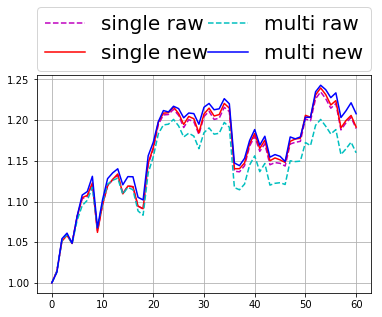

In [133]:
plt.plot(range(len(single_raw_result)), single_raw_result/10000, 'm--', label='single raw')
plt.plot(range(len(single_new_result)), single_new_result/10000, 'r-', label='single new')
plt.plot(range(len(single_raw_result)), np.array(lr_raw_result)/10000, 'c--', label='multi raw')
plt.plot(range(len(single_new_result)), np.array(lr_new_result)/10000, 'b-', label='multi new')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=20)
plt.grid(True)

plt.savefig('profit_2015', bbox_inches = 'tight')